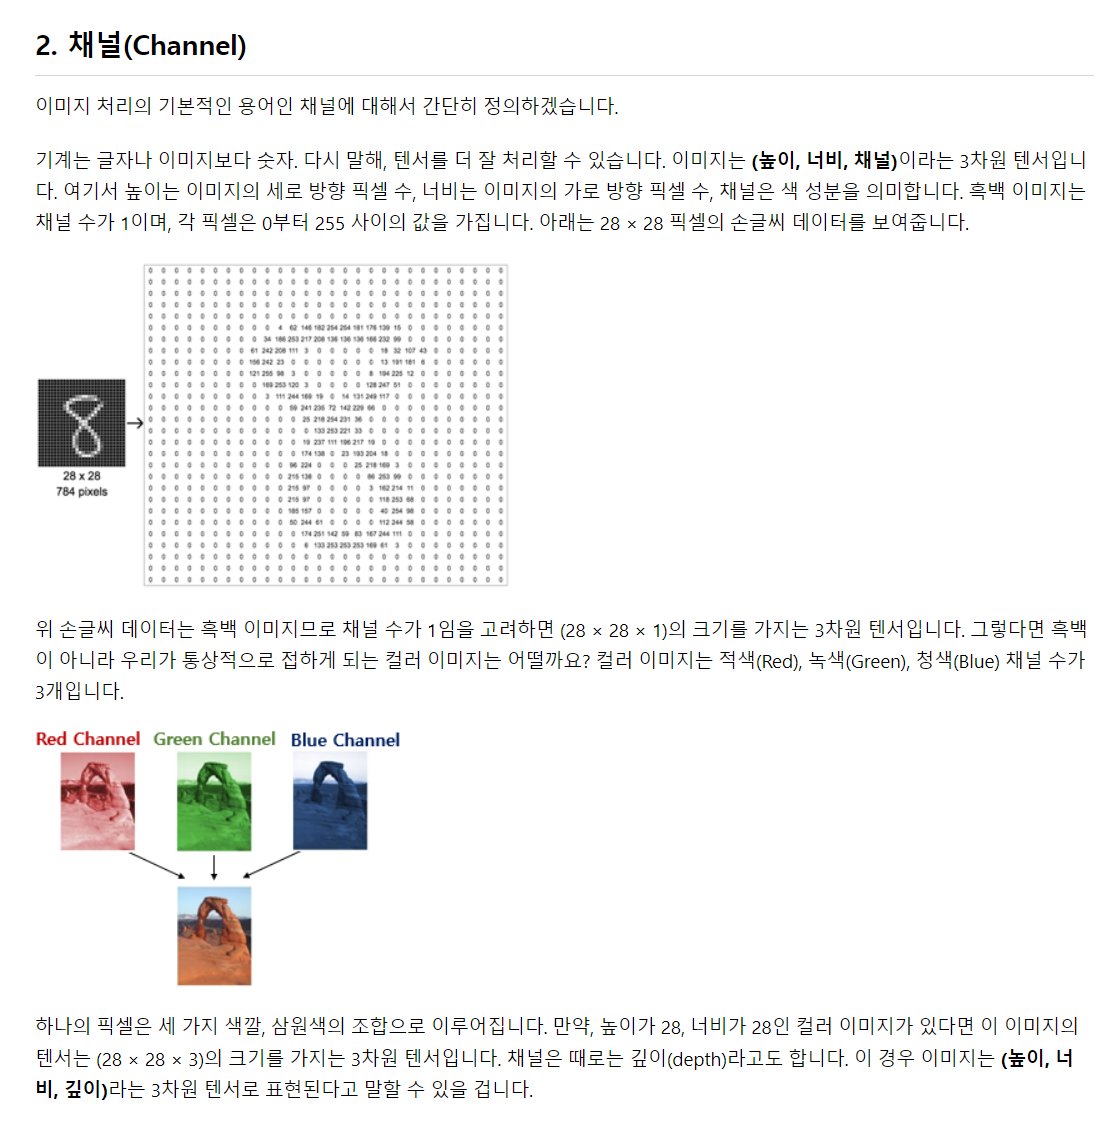

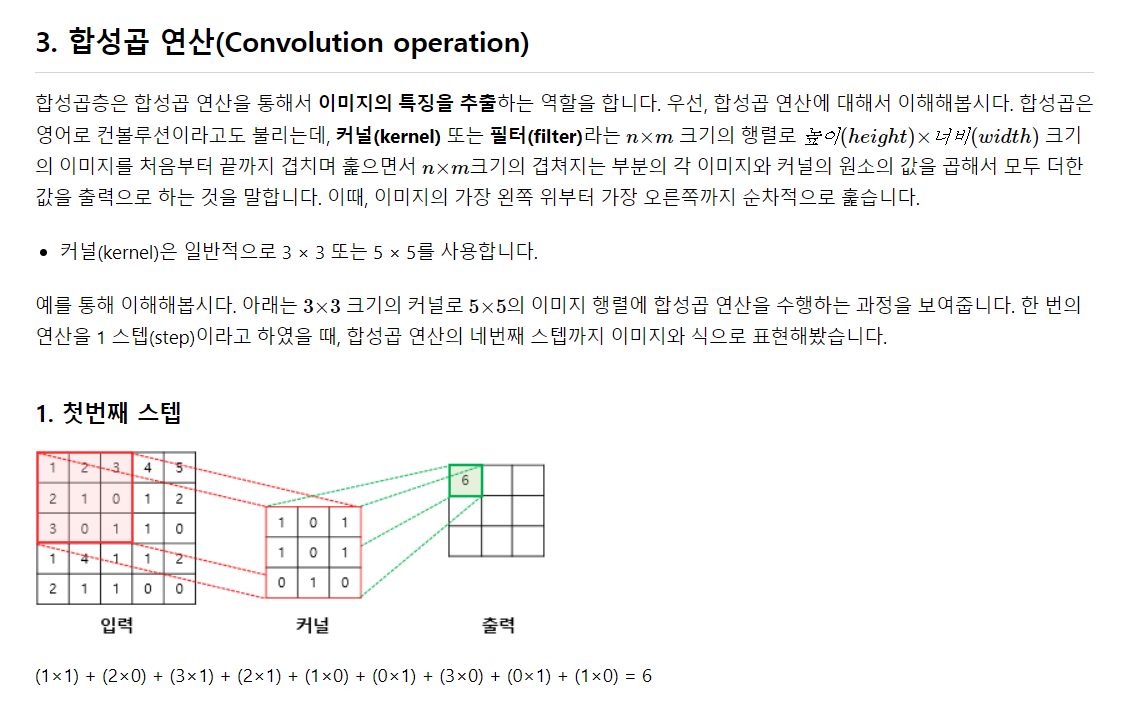

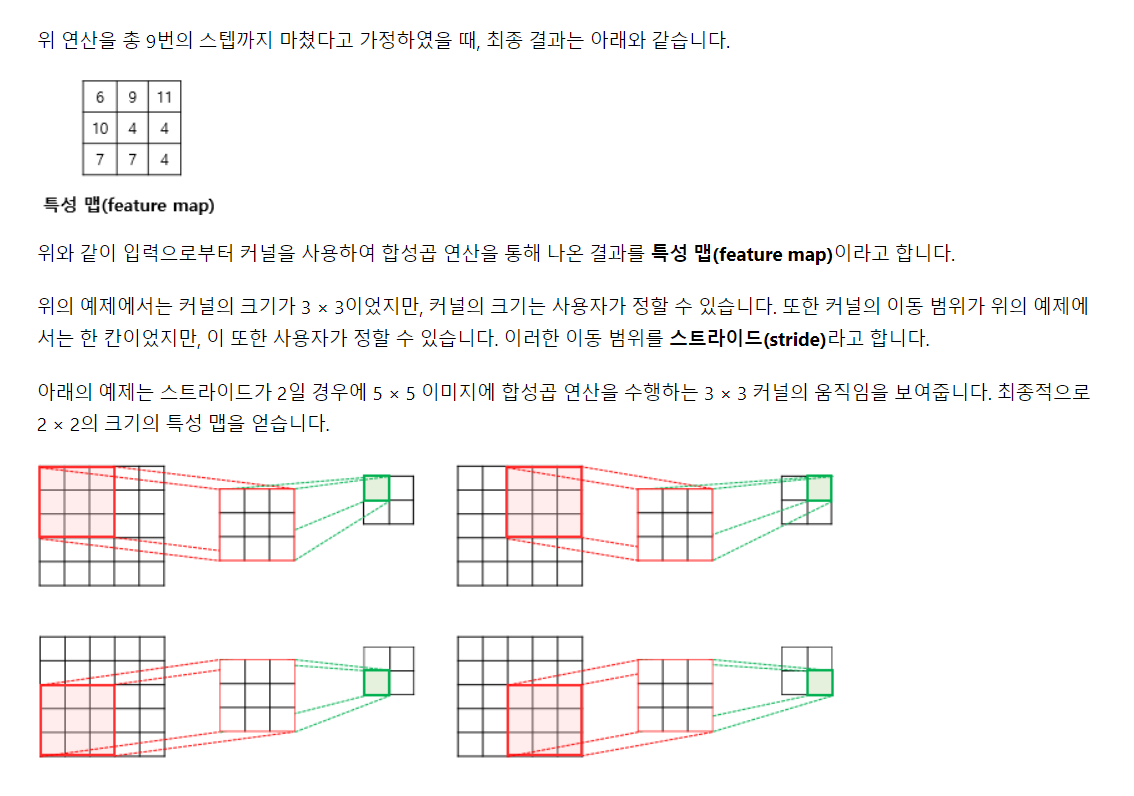

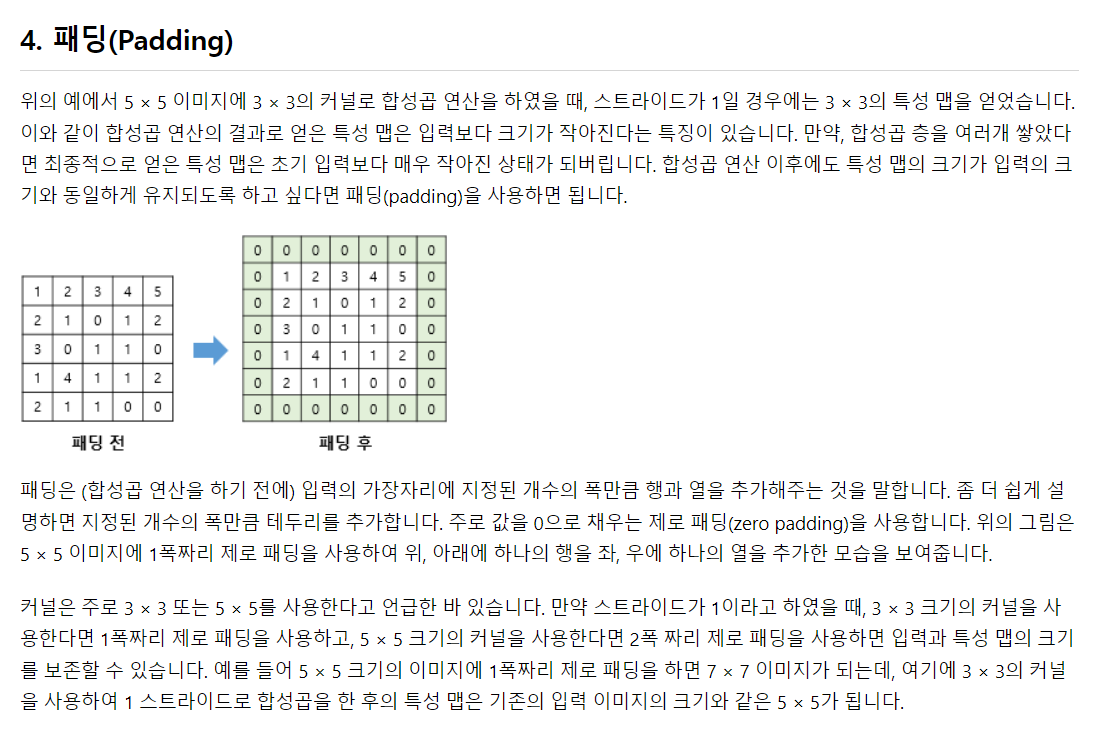

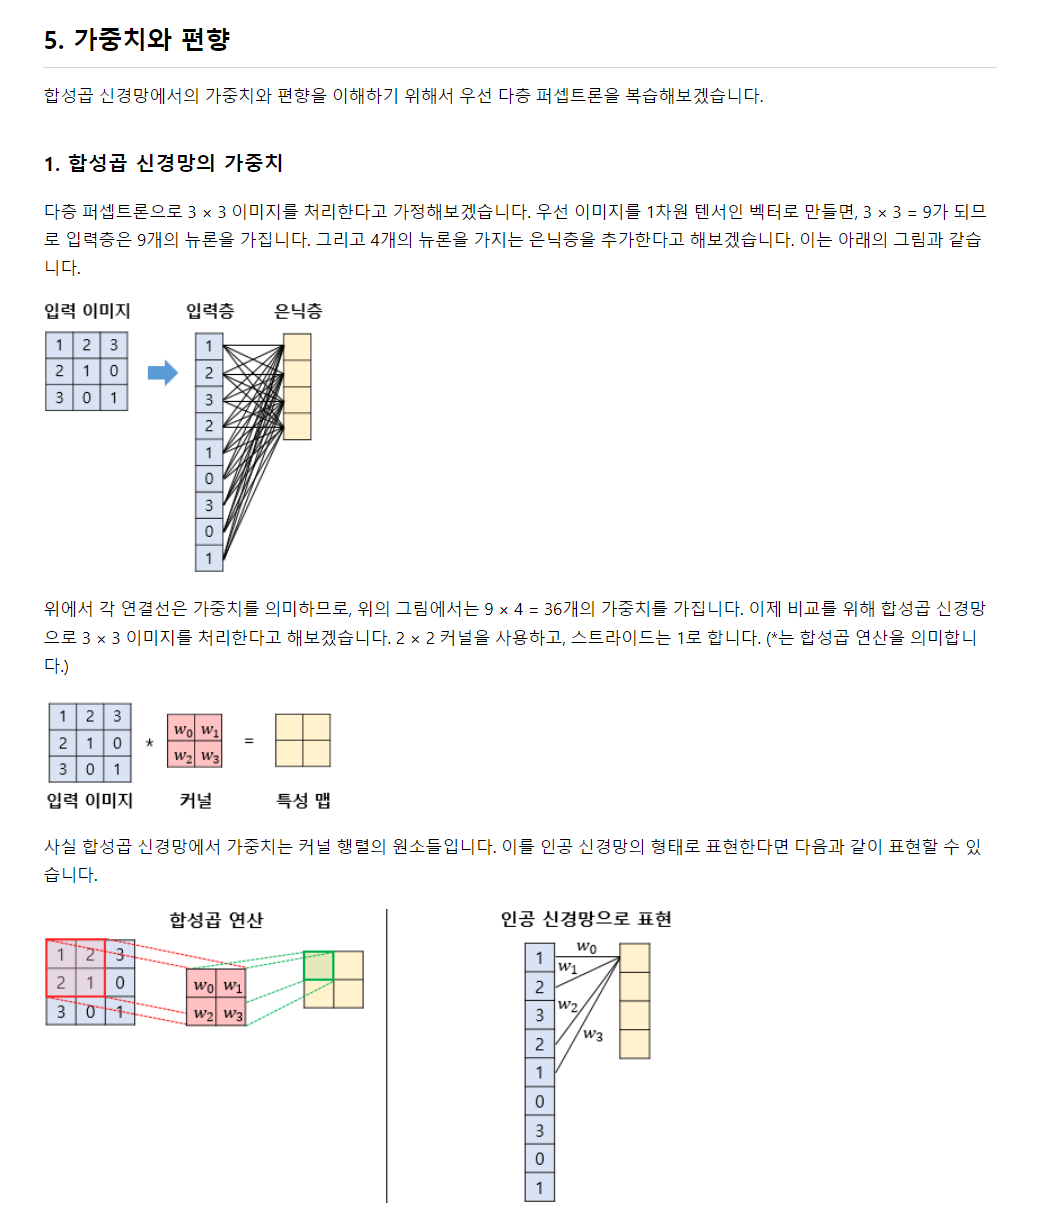

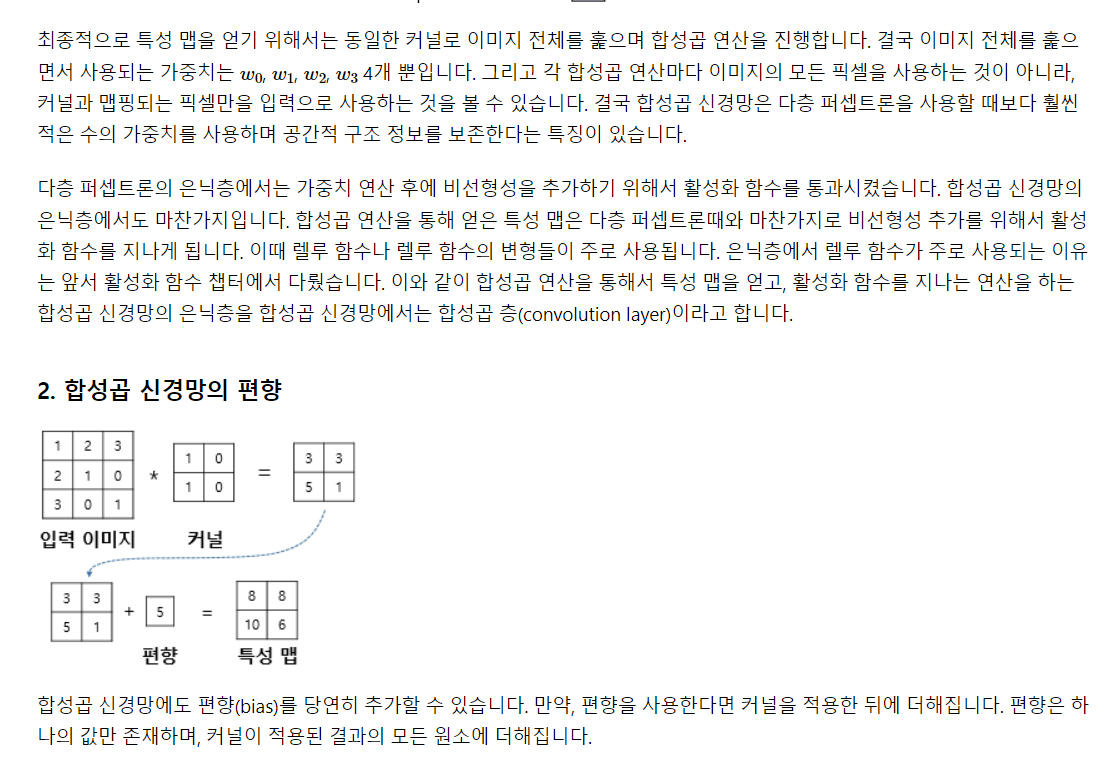

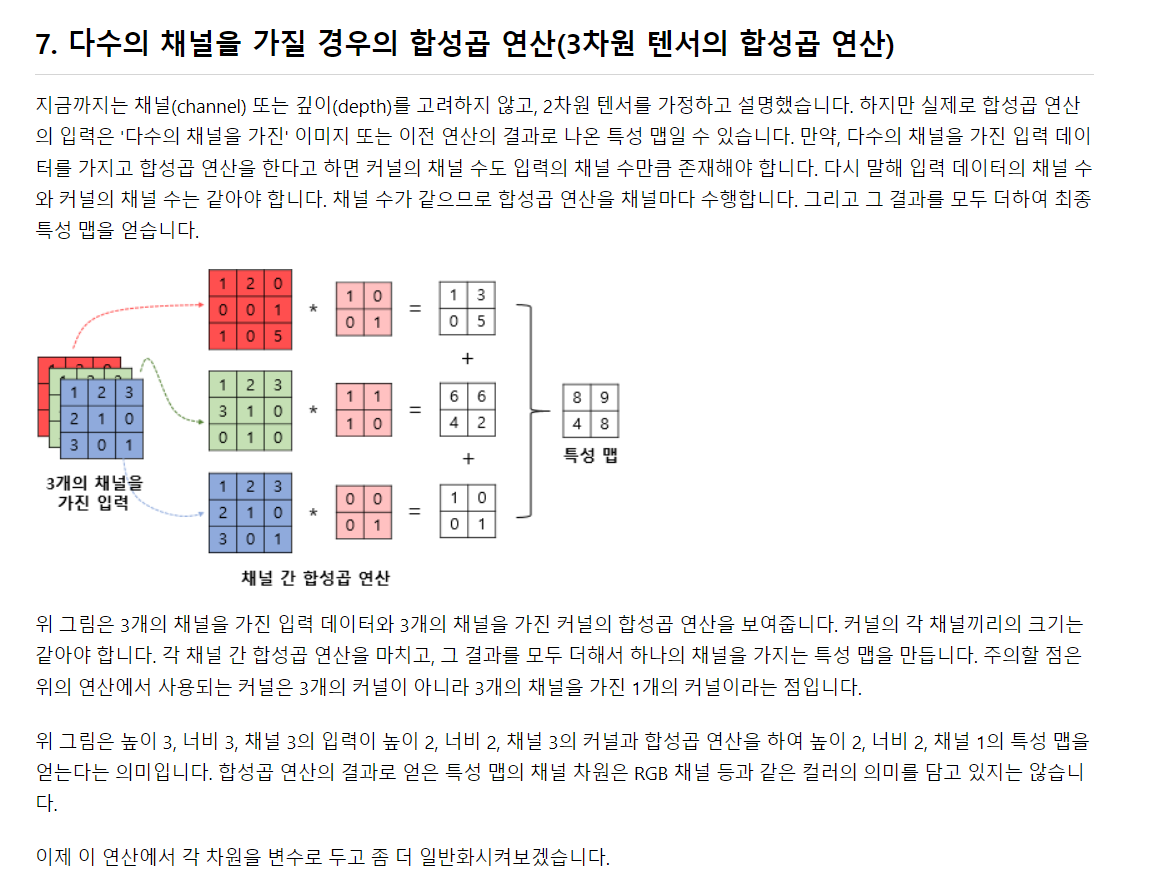

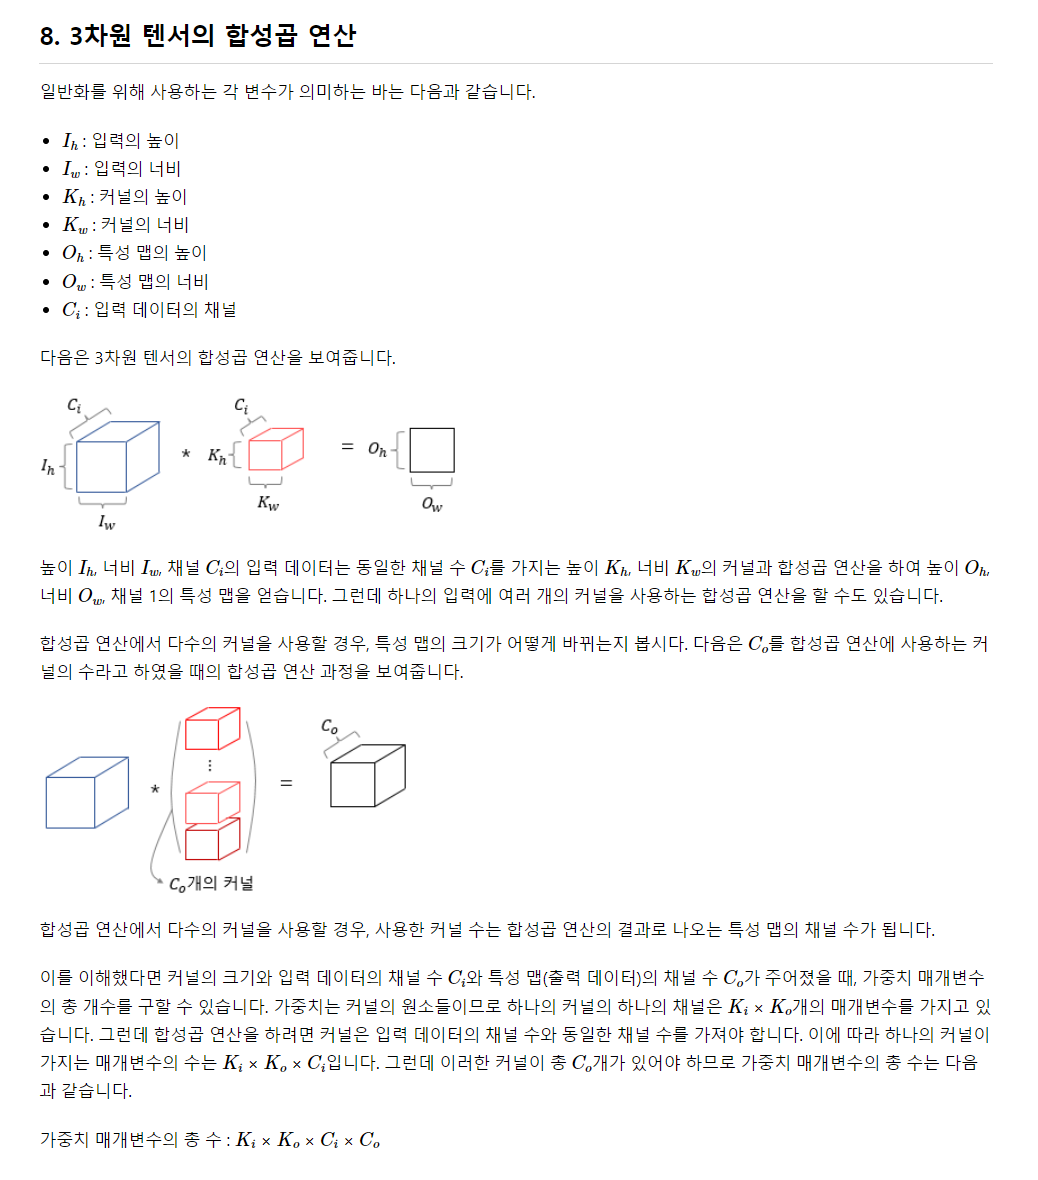

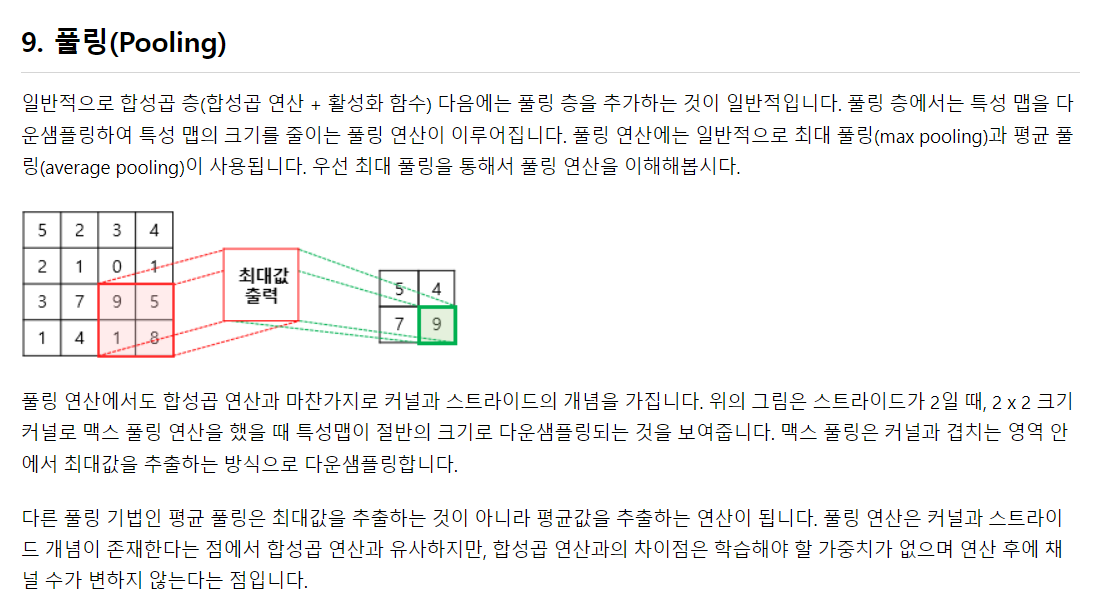

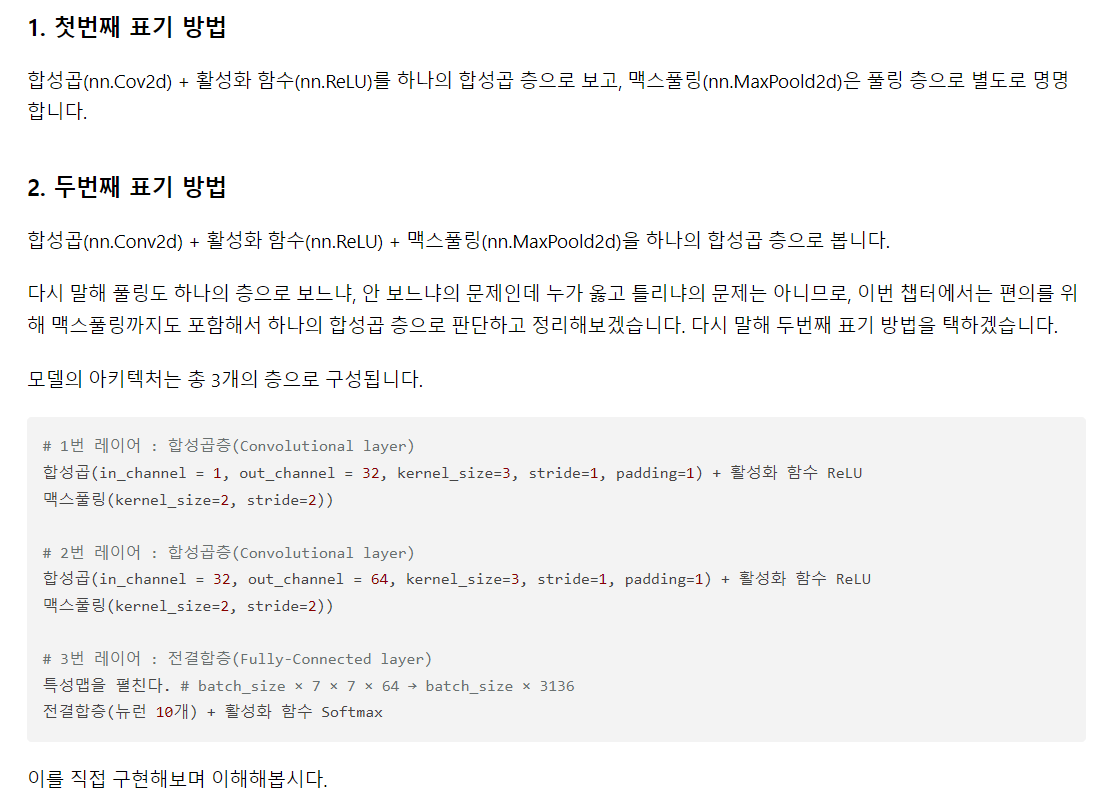

In [19]:
import torch
import torch.nn as nn

In [20]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 28, 28])


In [21]:
# 이제 첫번째 합성곱 층을 구현해봅시다. 1채널 짜리를 입력받아서 32채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1입니다.

conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [22]:
# 이제 두번째 합성곱 층을 구현해봅시다. 32채널 짜리를 입력받아서 64채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1입니다.

conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [23]:
# 이제 맥스풀링을 구현해봅시다. 정수 하나를 인자로 넣으면 커널 사이즈와 스트라이드가 둘 다 해당값으로 지정됩니다.

pool = nn.MaxPool2d(2)
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


지금까지는 선언만한 것이고 아직 이들을 연결시키지는 않았습니다. 이들을 연결시켜서 모델을 완성시켜보겠습니다. 우선 입력을 첫번째 합성곱층을 통과시키고 합성곱층을 통과시킨 후의 텐서의 크기를 보겠습니다.

In [24]:
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


32채널의 28너비 28높이의 텐서가 되었습니다. 32가 나온 이유는 conv1의 out_channel로 32를 지정해주었기 때문입니다. 또한, 28너비 28높이가 된 이유는 패딩을 1폭으로 하고 3 × 3 커널을 사용하면 크기가 보존되기 때문입니다. 이제 이를 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기를 보겠습니다.

In [25]:
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


32채널의 14너비 14높이의 텐서가 되었습니다. 이제 이를 다시 두번째 합성곱층에 통과시키고 통과한 후의 텐서의 크기를 보겠습니다.

In [26]:
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


64채널의 14너비 14높이의 텐서가 되었습니다. 64가 나온 이유는 conv2의 out_channel로 64를 지정해주었기 때문입니다. 또한, 14너비 14높이가 된 이유는 패딩을 1폭으로 하고 3 × 3 커널을 사용하면 크기가 보존되기 때문입니다. 이제 이를 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기를 보겠습니다. 이제 이를 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기를 보겠습니다.

In [27]:
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


이제 이 텐서를 펼치는 작업을 할 겁니다. 그런데 펼치기에 앞서 텐서의 n번째 차원을 접근하게 해주는 .size(n)에 대해서 배워보겠습니다. 현재 out의 크기는 1 × 64 × 7 × 7입니다. out의 첫번째 차원이 몇인지 출력해보겠습니다.

In [28]:
# out의 첫번째 차원은 1입니다.
out.size(0)

1

In [29]:
# out의 네번째 차원을 출력해보겠습니다.
out.size(3)

7

In [30]:
# 이제 이를 가지고 .view()를 사용하여 텐서를 펼치는 작업을 해보겠습니다.
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3136])


배치 차원을 제외하고 모두 하나의 차원으로 통합된 것을 볼 수 있습니다. 이제 이에 대해서 전결합층(Fully-Connteced layer)를 통과시켜보겠습니다. 출력층으로 10개의 뉴런을 배치하여 10개 차원의 텐서로 변환합니다.

In [31]:
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


### CNN으로 MNIST 분류하기

In [32]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [34]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [35]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [36]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [38]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [39]:
# CNN 모델 정의
model = CNN().to(device)

In [40]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


총 배치의 수는 600입니다. 그런데 배치 크기를 100으로 했으므로 결국 훈련 데이터는 총 60,000개란 의미입니다. 이제 모델을 훈련시켜보겠습니다. (시간이 꽤 오래 걸립니다.)

In [42]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.228713349
[Epoch:    2] cost = 0.0667579845
[Epoch:    3] cost = 0.0489753522
[Epoch:    4] cost = 0.0398760624
[Epoch:    5] cost = 0.0331255272
[Epoch:    6] cost = 0.0276018605
[Epoch:    7] cost = 0.0236826222
[Epoch:    8] cost = 0.0201681461
[Epoch:    9] cost = 0.0170754939
[Epoch:   10] cost = 0.0149474433
[Epoch:   11] cost = 0.0128613478
[Epoch:   12] cost = 0.0102722449
[Epoch:   13] cost = 0.00955884624
[Epoch:   14] cost = 0.00904555339
[Epoch:   15] cost = 0.00730634201


In [43]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9835000038146973


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
